In [462]:
# import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, lognorm, uniform, norm
from scipy.optimize import minimize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import dill
import scipy

P1)

a) Load up the samples and evaluate its E[X] and Var[X].

In [455]:
samples = np.loadtxt('samples.txt')

In [456]:
mean = np.mean(samples)
var = np.var(samples)
print(f'mean: {mean}, var: {var}')

mean: 0.5437645281730253, var: 0.0675735291846737


b)  According to the method of moments: α = E[X]•(((1-E[X])/Var[X])-1)•E[X] and β = E[X]•(((1-E[X])/Var[X])-1)•(1-E[X]). Therefore our initial values will be α and β according to the aforementioned formulas. How we arrive to our log beta function to minimize using MLE, is described in the other homeowrk document.

In [463]:
def log_beta(theta, samples):
  L = -1 * np.sum(scipy.stats.beta.logpdf(samples, theta[0], theta[1]))
  return L

In [458]:
alpha_0 = (mean * (((1 - mean)/var) - 1)) * mean
beta_0 = (mean * (((1 - mean)/var) - 1)) * (1 - mean)
print(f'Initial alpha guess: {alpha_0}\nInitial beta guess: {beta_0}')

Initial alpha guess: 1.7006586897308347
Initial beta guess: 1.426905911521873


In [464]:
res = minimize(log_beta, [alpha_0, beta_0], args=samples,
                       method='L-BFGS-B', bounds=[(None, None), (1e-6, None)])
alpha, beta = res.x
print(f'MLE for alpha: {alpha}\nMLE for beta: {beta}')

MLE for alpha: 1.348988009832874
MLE for beta: 1.1542991111217344


c) Compare the mean and variance of the beta pdf and samples. 

In [465]:
stats = scipy.stats.beta.stats(alpha, beta)
beta
print(f'Beta pdf:\nMean: {stats[0]}\nVariance: {stats[1]}')

Beta pdf:
Mean: 0.5388866496938027
Variance: 0.07092990665517623


2) We first open up the pickle file for our target density and define another function to evaluate it across alll possible points in the domain. 

In [137]:
with open("target_density.pkl", 'rb') as fs:
    target_pdf = dill.load(fs)


def pdf(x):
    values = [target_pdf(i) for i in x]
    return np.array(values)

In [ ]:
grid_points = np.column_stack([X.ravel(), Y.ravel()])
pi_values = pdf(grid_points)

a) We try to create q(x) given that we already have π(x). We also need to consider the dimension n = 2. It is a bivariate distribution and the uniform distribution q(x) will consist of a square of 12 x 12 centered around the origin x = [0, 0]T. 

In [138]:
# We define our space

x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x, y)

# We define q(b - a) as 1 / (b-a)^2. Therefore q(6 - (-6)) = 1 / 144. 

In [432]:
n_samples = 1000
n_trials = 0
i = 0
M = 2.3
M_max = 2
samples = []
while i <= n_samples:
    u = np.random.rand()
    x_c = np.random.uniform(-6, 6, size=(1, 2))
    quot = pdf(x_c)/(M*(1/144))
    M_max=max(M_max, quot)
    if u < (quot/M):
        samples.append(x_c)
        i += 1
    n_trials += 1


We print the efficiency and best efficiency.

In [440]:
print(f'Efficiency: {n_samples/n_trials}')
print(f'Number of trials: {n_trials}')
print('Best efficiency:', 1/12.8)

Efficiency: 0.17809439002671415
Number of trials: 5615
Best efficiency: 0.078125


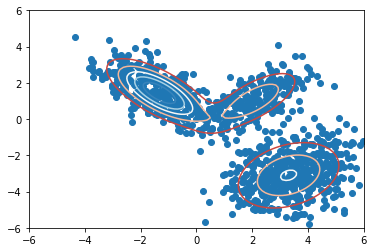

In [435]:
# samples = np.array(samples)
#  fig, ax = plt.subplots()
# ax.scatter(samples[:, 0].reshape(1001, 2)[:, 0], samples[:, 0].reshape(1001, 2)[:, 1])
# ax.contour(X, Y, pi_values.reshape(X.shape), cmap='RdBu')

b) We define our gaussian annd write down its components, making it dependent on x and sigma.

In [202]:
def gaussian(x, sigma):
    return (1 / (2 * np.pi * sigma**2)) * np.exp(-0.5 * np.sum(x**2, axis=1) / sigma**2)

In [446]:
M_gauss = (pdf(grid_points) / gaussian(grid_points, 3.5)).max()
print(M_gauss)

8.887541929405653


In [450]:
n_samples = 1000
n_trials = 0
i = 0
M = 3
M_max = 2
sigma = 3.5
samples2 = []
while i <= n_samples:
    u = np.random.rand()
    x_c = np.random.normal(0, sigma, size=(1, 2))
    quot = target_pdf(x_c)/(M*gaussian(x_c, sigma))
    M_max=max(M_max, quot)
    if (quot/M)>u:
        samples2.append(x_c)
        i += 1
    n_trials += 1

samples2 = np.array(samples2)


In [453]:
print(n_samples/n_trials)
print(n_trials)
print(1/M_max)

0.10808473843493299
9252
[0.33925445]


c) To find our potential maximas, we need to see where the graph appears to be more dense in samples, and propose those as our starting points. 

Text(0.5, 1.0, 'Scattered samples of q(x_c)')

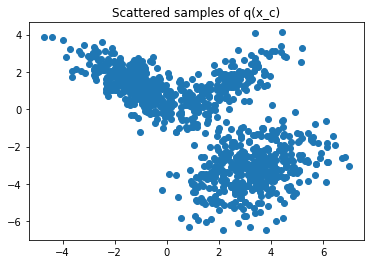

In [314]:
fig, ax = plt.subplots()
ax.scatter(samples2[:, 0].reshape(1001, 2)[:, 0], samples2[:, 0].reshape(1001, 2)[:, 1])
ax.set_title("Scattered samples of q(x_c)")
# ax.contour(X, Y, pi_values.reshape(X.shape), cmap='RdBu')

Accordingg to the scatter plot, 3 maximas are hypothesized and give a rough guess of there location based on the sample distribution.

In [454]:
starting_points = [[3.8, -3],
                   [-1, 1.5],
                   [2.2, 2]]
maxima = []

for x0 in starting_points:
    res = minimize(lambda x: -target_pdf(x), x0, method='L-BFGS-B')
    maxima.append((res.x, target_pdf(res.x)))

print("Located maxima:")
for x, z in maxima:
    print(f"  x* ≈ {x}, π(x*) ≈ {z}")


Located maxima:
  x* ≈ [ 3.30494006 -3.10298194], π(x*) ≈ 0.04634473853631503
  x* ≈ [-1.32299727  1.44298855], π(x*) ≈ 0.08914467910803087
  x* ≈ [2.05146137 1.03314297], π(x*) ≈ 0.044590730433528264


d) Plot the target pdf π(x) in a scatter and surface plot. 

Text(0.5, 0.92, 'Surface and contour graph of π(x)')

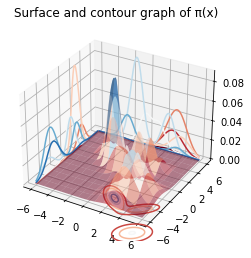

In [339]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(X, Y, pi_values.reshape(X.shape), lw=0.5, rstride=8, cstride=8,
                alpha=0.5, cmap='RdBu')
ax.contour(X, Y, pi_values.reshape(X.shape), zdir='z', offset=-0.04, cmap='RdBu')
ax.contour(X, Y, pi_values.reshape(X.shape),zdir='x', offset=-6, cmap='RdBu')
ax.contour(X, Y, pi_values.reshape(X.shape), zdir='y', offset=6, cmap='RdBu')
ax.set_title('Surface and contour graph of π(x)')